# Single Level Model
In our simplest model, we will just model each post.

Have found this to be a useful resource for a hierarchcal model example: https://github.com/pyro-ppl/pyro/blob/dev/examples/baseball.py
As well as https://pyro.ai/examples/forecasting_iii.html

# To start, we will use dummy data

In [66]:
import json
import numpy as np
import pandas as pd
import torch

In [67]:
# import torch
# import pyro
# from pyro.infer import MCMC, NUTS
# import pyro.distributions as dist
# from pyro.distributions.util import scalar_like
# from torch.distributions import constraints
# import json

In [68]:
# pyro.enable_validation(__debug__)
# pyro.set_rng_seed(0)

First, we load the Reddit datasets

In [69]:
comments = dict()
with open('../data/results/Comments.json') as f:
    for line in f:
        post = json.loads(line)
        comments[post['pid']] = post['api_num_comments'], post['comments']

In [70]:
corrections = []
with open('../data/results/CorrectionPairs.json') as f:
    for line in f:
        corrections.append(json.loads(line))

In [71]:
news = []
with open('../data/results/NewsPairs.json') as f:
    for line in f:
        news.append(json.loads(line))

Gather relevant variables

In [72]:
def processData(data, items, comments, minutes=60, offset=0):
    for idx, n in enumerate(items):
        i = idx + offset
        
        isNews = 'isFakeStory' in n['r']['reviewRating']
        news_id = n['p']['id']
        
        num_cmts, cmts = comments[news_id]
        c_body_lens = []
        c_ups = []
        c_downs = []
        unique_authors = set()
        for c in cmts:
            # skip if comment not created in first _ mins
            if c['delta_seconds'] > minutes * 60:
                continue

            c_minutes = c['delta_seconds'] / 60
            if c_minutes <= minutes:   # cmts in first _ mins
                data[i, 7] += 1
            
            c_body_lens.append(c['body_len'])
            c_ups.append(c['ups'])
            c_downs.append(c['downs'])
            
            if c['author']:
                unique_authors.add(c['author'])

        data[i, 0] = num_cmts
        if isNews:
            data[i, 1] = 1 if n['r']['reviewRating']['isFakeStory'] else 0
        else:
            data[i, 1] = 3 if n['r']['reviewRating']['isFakeClaim'] else 2
        data[i, 2] = np.mean(c_body_lens) if c_body_lens else 0.
        data[i, 3] = np.std(c_body_lens) if c_body_lens else 0.
        data[i, 4] = np.mean(c_ups) if c_ups else 0.
        data[i, 5] = np.std(c_ups) if c_ups else 0.
        data[i, 6] = len(unique_authors) if unique_authors else 0.
    return data

In [73]:
import torch

In [74]:
num_p_indep = 8
data = torch.zeros((len(news) + len(corrections), num_p_indep))

data = processData(data, news, comments)
data = processData(data, corrections, comments, offset=len(news))

Variables (in order):

0. num_comments
1. type
2. comment_length_avg
3. comment_length_std
4. comment_upvotes_avg
5. comment_upvotes_std
6. num_unique_comment_authors
7. num_comments in first _ mins

In [75]:
# select relevant indep vars
p_data = data[:, (2,4,6,7)]  # avg cmt length, avg upvotes, num authors
t_data = data[:,1].reshape(-1,1)

# add bias terms
biases = torch.ones_like(t_data)
p_data = torch.cat((biases, p_data), dim=1)
t_data = torch.cat((biases, t_data), dim=1)

# get dep var
y = data[:,0].reshape(-1,1)

-----

# USING NUMPYRO

Post-Level Regression

y_p = phi_0 * bias + phi_1 * first_hour_comments + epsilon

In [11]:
import numpyro
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from numpyro.distributions import constraints
from jax import random

from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer import Predictive
import numpyro.optim as optim
from jax import lax, random
import matplotlib.pyplot as plt

In [12]:
p_data = jnp.array(p_data)
y = jnp.array(y)

In [13]:
def model(p_data, y):
    num_posts, num_p_indeps = p_data.shape

    # define a prior for our regression variables
    phi_prior = dist.Normal(jnp.zeros((num_p_indeps, 1)),
                            10. * jnp.ones((num_p_indeps, 1)))  # (num_p_indeps, 1)
    phi = numpyro.sample("phi", phi_prior)  # (num_p_indeps, 1)
    
    # for each post, use the correct set of coefficients to run our post-level regression
    with numpyro.plate("post", num_posts, dim=-1) as p:

        # indep vars for this post
        indeps = p_data[p,:]  # (num_posts, num_p_indeps)
        
        # calculate the mean
#        mu = torch.matmul(indeps, phi)  # (num_posts, num_p_indeps) (num_p_indeps, 1)
        mu = jnp.matmul(indeps, phi)  # (num_posts, num_p_indeps) (num_p_indeps, 1)
        
        # sample
        numpyro.sample("obs", dist.Normal(mu, 1000.), obs=y[p])  # (num_posts, 1)

In [14]:
def guide(p_data, y):
    num_posts, num_p_indeps = p_data.shape
    
    phi_loc = numpyro.param("phi_loc", jnp.zeros((num_p_indeps, 1)))
    phi_scale = numpyro.param("phi_scale", jnp.ones((num_p_indeps, 1)), constraint=constraints.positive)

    # define a prior for our regression variables
    phi_prior = dist.Normal(phi_loc, phi_scale)  # (num_p_indeps, 1)
    phi = numpyro.sample("phi", phi_prior)  # (num_p_indeps, 1)

In [78]:
p_data.shape

torch.Size([21830, 5])

In [82]:
p_data_sub, y_sub = jnp.array(p_data[:100,:]), jnp.array(y[:100])

In [83]:
svi = SVI(model,
          guide,
          optim.Adam(step_size=.1),
          loss=Trace_ELBO())

num_iters = 2000
init_state = svi.init(random.PRNGKey(1), p_data_sub, y_sub)
state = lax.fori_loop(0, num_iters, lambda i, state: svi.update(state, p_data_sub, y_sub)[0], init_state)

# state, losses = lax.scan(lambda state, i: svi.update(state, p_data, y), init_state, jnp.arange(num_iters))


In [84]:
params = svi.get_params(state)

In [45]:
state

SVIState(optim_state=(DeviceArray(100, dtype=int32), OptimizerState(packed_state=([DeviceArray([[ 2.7416782 ],
             [-0.00769409],
             [ 5.084066  ],
             [ 4.1878076 ],
             [ 4.324857  ]], dtype=float32), DeviceArray([[ -525.91266],
             [33234.312  ],
             [-7123.91   ],
             [14662.41   ],
             [13475.724  ]], dtype=float32), DeviceArray([[2.2992862e+06],
             [5.0968868e+11],
             [8.8664472e+07],
             [8.3912074e+09],
             [3.2297300e+10]], dtype=float32)], [DeviceArray([[-0.2902424 ],
             [-2.0216324 ],
             [-0.7812578 ],
             [-0.62391996],
             [-1.1131371 ]], dtype=float32), DeviceArray([[  504.0776],
             [91891.95  ],
             [ 1997.8821],
             [ 8961.99  ],
             [33440.414 ]], dtype=float32), DeviceArray([[4.3788615e+06],
             [5.5198096e+11],
             [6.8574520e+07],
             [6.6100977e+09],
     

[]

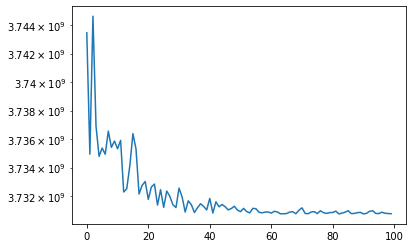

In [53]:
plt.yscale("log")
plt.plot(losses)
plt.plot()

In [85]:
params

{'phi_loc': DeviceArray([[ 2.550797  ],
              [-0.01555137],
              [ 1.5054204 ],
              [ 5.062389  ],
              [ 6.548301  ]], dtype=float32),
 'phi_scale': DeviceArray([[7.8241134 ],
              [0.06345712],
              [3.9073033 ],
              [3.6758745 ],
              [3.5490658 ]], dtype=float32)}

In [94]:
m = pd.DataFrame(posterior_samples['phi'][:,:,0])
m.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()

,count,mean,std,min,5%,25%,50%,75%,95%,max
0,2000.0,2.506603,7.146449,-18.917931,-9.100892,-2.421920,2.630469,7.426182,14.444264,22.790255
1,2000.0,0.045231,0.068144,-0.169047,-0.066420,-0.000283,0.045535,0.090908,0.156516,0.270646
2,2000.0,1.231525,7.220015,-23.942242,-10.388513,-3.841995,1.144457,6.121388,12.943190,26.635326
3,2000.0,5.122753,8.514274,-23.567450,-8.058246,-1.034082,5.072981,10.848866,19.189232,34.254272
4,2000.0,6.534877,6.865974,-14.878880,-4.897504,1.834624,6.489768,11.286727,17.850338,31.334137


In [64]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(p_data, y).items()
               if k != "obs"}

ValueError: too many values to unpack (expected 2)

In [65]:
predictive(p_data, y)

ValueError: too many values to unpack (expected 2)

In [97]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=20000, num_warmup=10000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, p_data_sub, y_sub)

sample: 100%|██████████| 30000/30000 [00:37<00:00, 802.74it/s, 15 steps of size 3.07e-01. acc. prob=0.92] 


In [98]:
!pip install arviz

     |████████████████████████████████| 1.5 MB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 720 kB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 3.0 MB/s eta 0:00:01     |█████████████▋                  | 1.3 MB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 295 kB 3.0 MB/s eta 0:00:01


In [104]:
import arviz as az
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=False);

AttributeError: 'Predictive' object has no attribute 'get_samples'

# NUMPYRO EXPERIMENT END

----

In [92]:
# nuts_kernel = NUTS(model)
# mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=1000)
# mcmc.run(p_data, y)

# print(mcmc.summary())
posterior_samples = mcmc.get_samples()

In [93]:
# Utility function to print latent sites' quantile information.
def summary_types(samples):
    site_stats = {}
    i = 0
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
        i += 1
    return site_stats

In [95]:
m = pd.DataFrame(hmc_samples['phi'][:,:,0])
m.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()

NameError: name 'hmc_samples' is not defined